# Data Preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, BatchNormalization, RepeatVector, TimeDistributed,
                                     Input, Flatten, Dropout)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
!gdown 1Hqd9z1c48DSb2McaENcG4KCOOBI0l0oF
!gdown 1-U03rNNIEJ1RhWWXL_pM4ReeqoETHyrl
!gdown 1v8hwhb1zJpLBb9XFAX3SEy1H_Gj4OXJT

Downloading...
From: https://drive.google.com/uc?id=1Hqd9z1c48DSb2McaENcG4KCOOBI0l0oF
To: /content/dftrain.h5
100% 825M/825M [00:09<00:00, 88.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-U03rNNIEJ1RhWWXL_pM4ReeqoETHyrl
To: /content/dfvalid.h5
100% 293M/293M [00:03<00:00, 81.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v8hwhb1zJpLBb9XFAX3SEy1H_Gj4OXJT
To: /content/dfvalid_groundtruth.csv
100% 5.25k/5.25k [00:00<00:00, 15.2MB/s]


In [3]:
train_data = pd.read_hdf('dftrain.h5')
test_data = pd.read_hdf('dfvalid.h5')
ground_truth = pd.read_csv('dfvalid_groundtruth.csv')

In [4]:
# Perform Fourier transform on each time series
fft_data_train = np.fft.fft(train_data, axis=1)
fft_data_test = np.fft.fft(test_data, axis=1)

# Calculate the absolute values of the complex Fourier coefficients
abs_fft_data_train = np.abs(fft_data_train)
abs_fft_data_test = np.abs(fft_data_test)

# Keep only the first half of the Fourier coefficients (because of the symmetry)
abs_fft_data_train = abs_fft_data_train[:, :(train_data.shape[1] // 2 + 1)]
abs_fft_data_test = abs_fft_data_test[:, :(test_data.shape[1] // 2 + 1)]

# Normalize the Fourier coefficients
normalized_fft_data_train = abs_fft_data_train / np.sum(abs_fft_data_train, axis=1, keepdims=True)
normalized_fft_data_test = abs_fft_data_test / np.sum(abs_fft_data_test, axis=1, keepdims=True)

# Print the shape of the normalized Fourier coefficients
print(normalized_fft_data_train.shape)
print(normalized_fft_data_test.shape)

(1677, 30721)
(594, 30721)


<ipython-input-4-23c022824cea>:15: RuntimeWarning: invalid value encountered in true_divide
  normalized_fft_data_test = abs_fft_data_test / np.sum(abs_fft_data_test, axis=1, keepdims=True)


# Exploratory Data Analysis

In [5]:
train_df = train_data.T
train_df.index=pd.to_timedelta(np.arange(61440), unit='ms')*1/1.024
test_df = test_data.T
test_df.index=pd.to_timedelta(np.arange(61440), unit='ms')*1/1.024

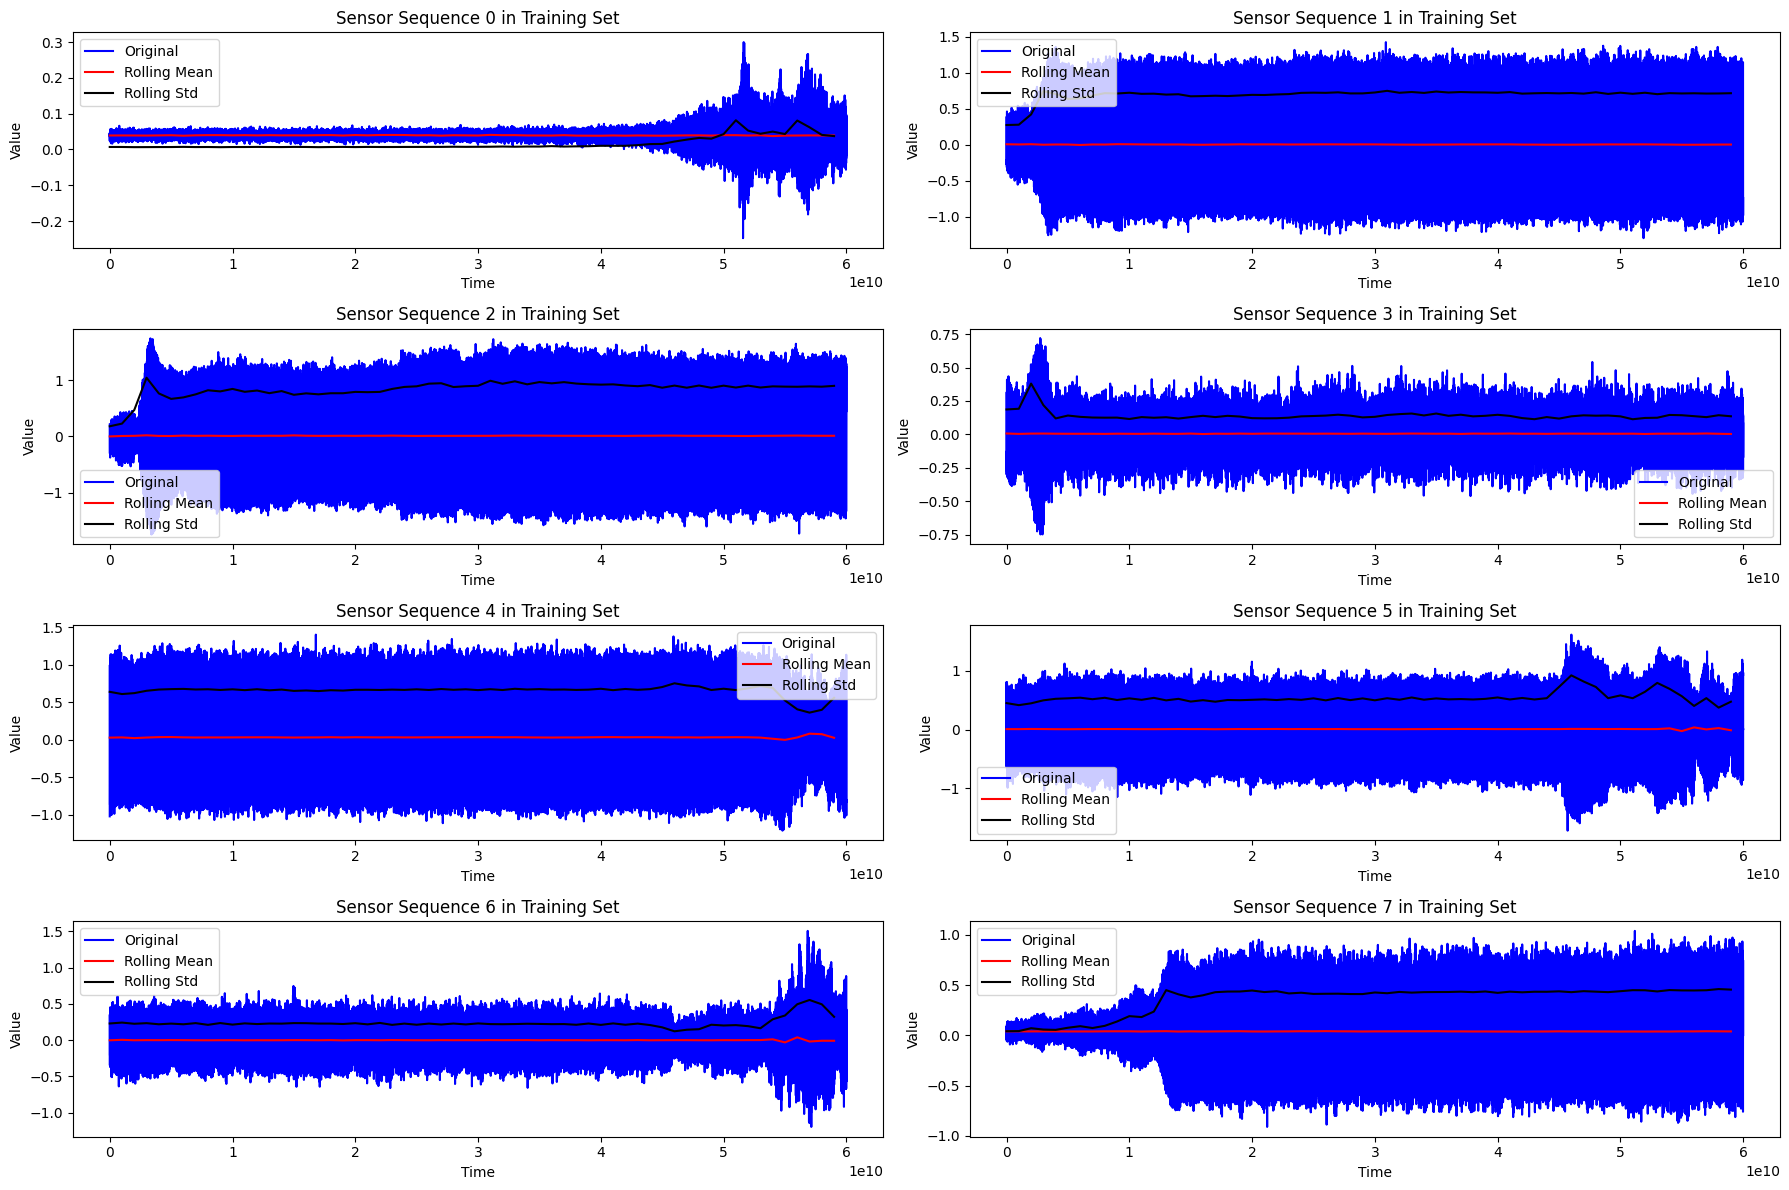

In [6]:
# Time Domain Visualisation of Train set
# Resample the entire dataset by daily average
names=train_df.iloc[:,0:8]
rollmean = names.resample(rule='s').mean()
rollstd = names.resample(rule='s').std()

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 12))

for i, name in enumerate(names):
    row = i // 2
    col = i % 2
    axs[row, col].plot(train_df[name], color='blue', label='Original')
    axs[row, col].plot(rollmean[name], color='red', label='Rolling Mean')
    axs[row, col].plot(rollstd[name], color='black', label='Rolling Std')
    axs[row, col].legend(loc='best')
    axs[row, col].set_title(f'Sensor Sequence {name} in Training Set')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')

plt.tight_layout()
plt.savefig('time_domain_visual.png', dpi=300)
plt.show()


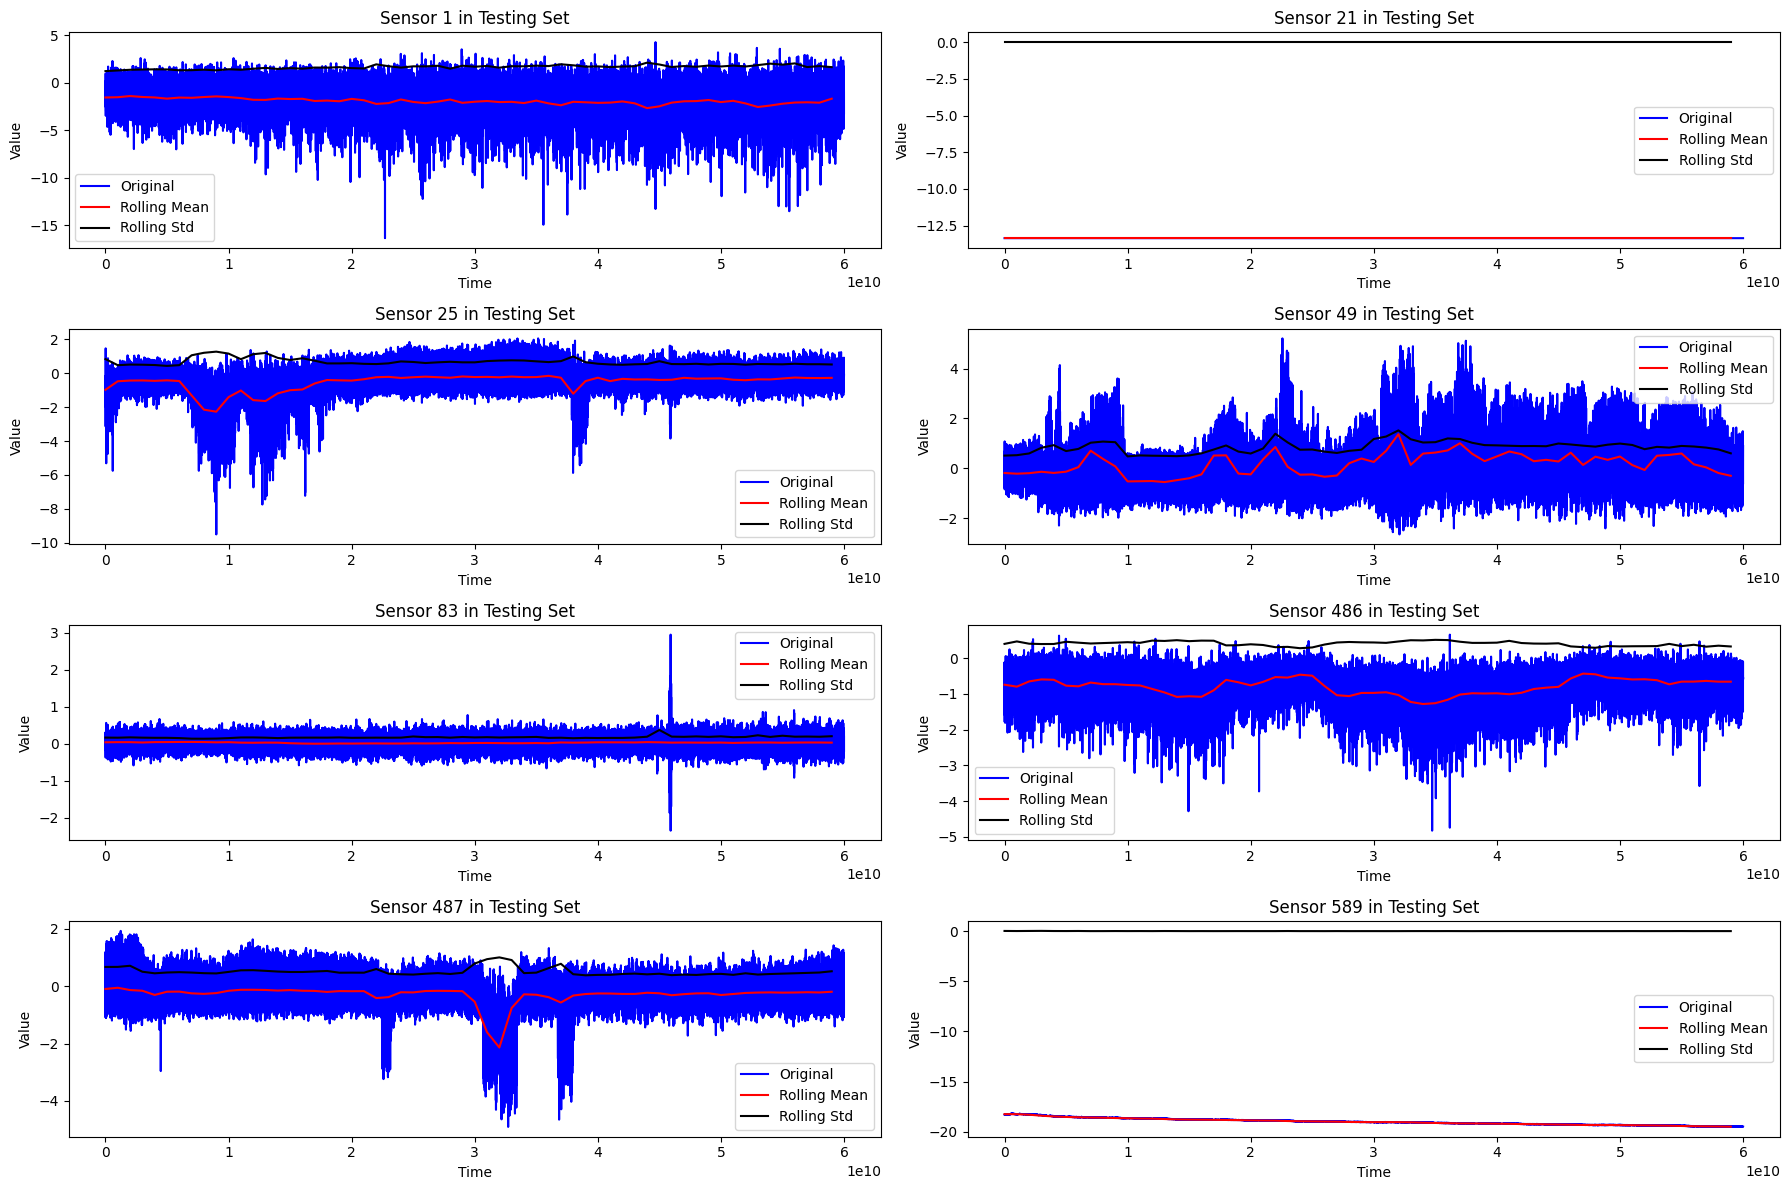

In [7]:
# Time Domain Visualisation of Test set
# Resample the entire dataset by daily average
names=test_df.iloc[:,[1,21,25,49,83,486,487,589]]
rollmean = names.resample(rule='s').mean()
rollstd = names.resample(rule='s').std()


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 12))

for i, name in enumerate(names):
    row = i // 2
    col = i % 2
    axs[row, col].plot(test_df[name], color='blue', label='Original')
    axs[row, col].plot(rollmean[name], color='red', label='Rolling Mean')
    axs[row, col].plot(rollstd[name], color='black', label='Rolling Std')
    axs[row, col].legend(loc='best')
    axs[row, col].set_title(f'Sensor {name} in Testing Set')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')

plt.tight_layout()
plt.savefig('time_domain_anomaly.png', dpi=300)
plt.show()

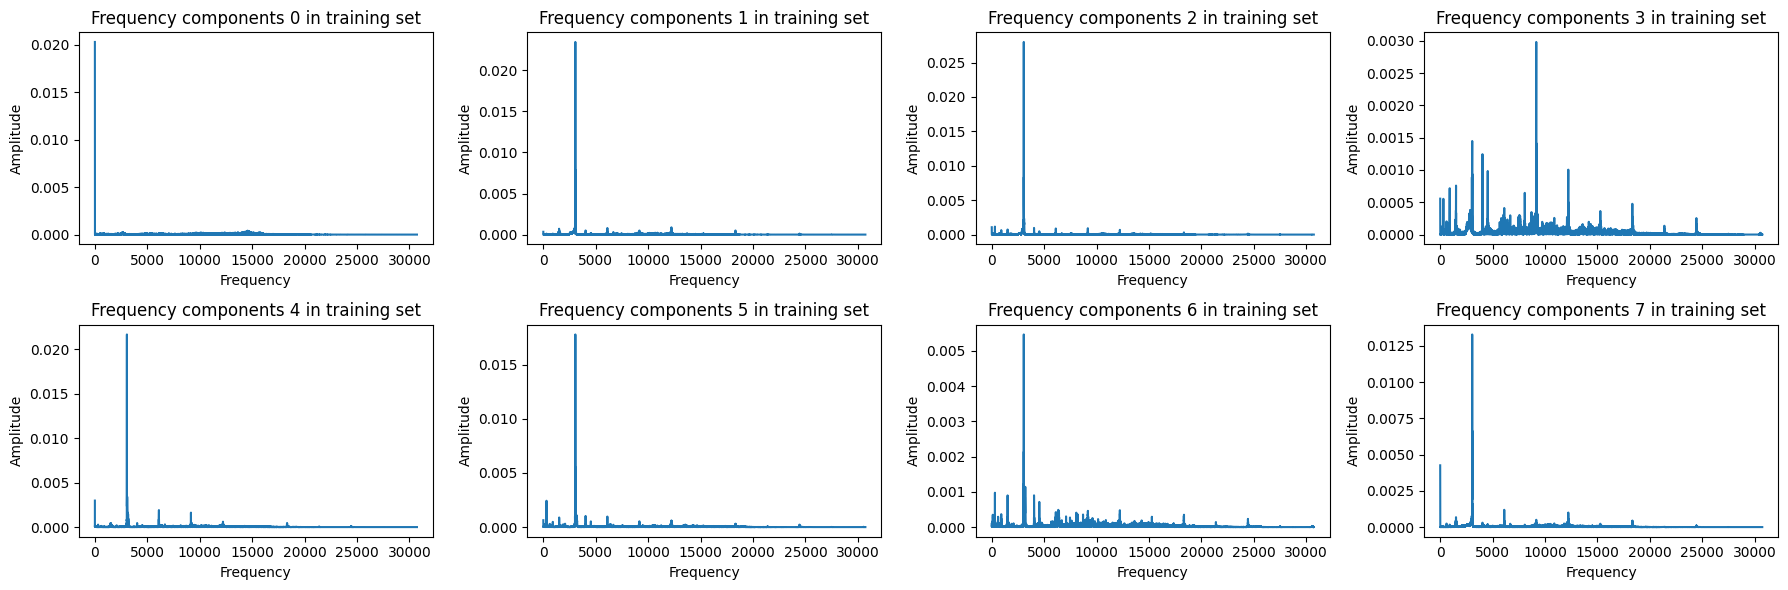

In [8]:
# Frequency Domain Visualisation of Train set
index_list = [i for i in range(0,8)]

fig, axs = plt.subplots(2, 4, figsize=(18, 6))
axs = axs.ravel()
for i, item in enumerate(index_list):
    axs[i].plot(normalized_fft_data_train[item])
    axs[i].set_title(f"Frequency components {item} in training set")
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Amplitude')
plt.tight_layout()
plt.savefig('freq_domain_visual.png', dpi=300)
plt.show()

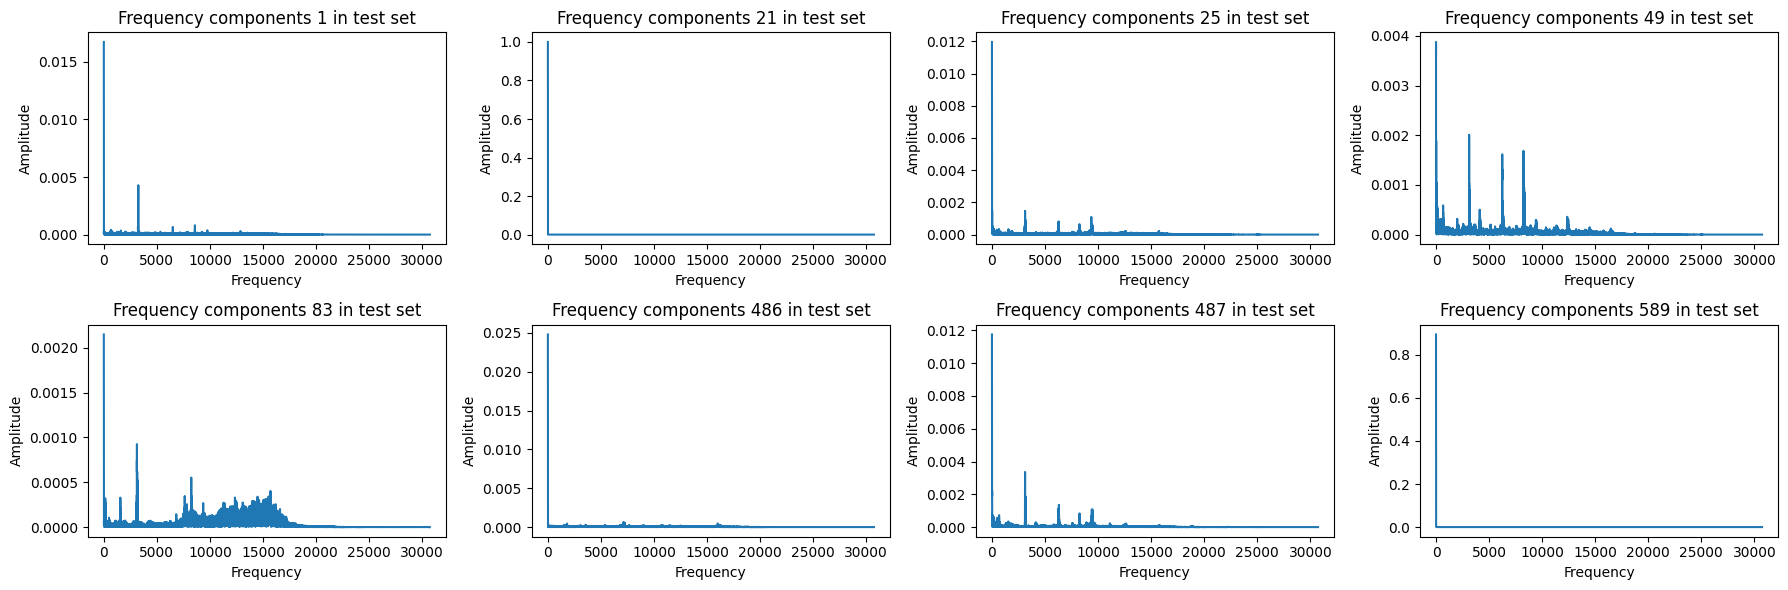

In [9]:
# Frequency Domain Visualisation of Train set
index_list = [1,21,25,49,83,486,487,589]

fig, axs = plt.subplots(2,4, figsize=(18, 6))
axs = axs.ravel()
for i, item in enumerate(index_list):
    axs[i].plot(normalized_fft_data_test[item])
    axs[i].set_title(f"Frequency components {item} in test set")
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Amplitude')
plt.tight_layout()
plt.savefig('freq_domain_anomaly.png', dpi=300)
plt.show()

# Loading Our Trained LSTM-AutoEncoder from Google Drive
This is for detecting anomalies mainly in time domain.

In [10]:
# Encoder
!gdown 1-28Szio-27NdNs8KTshlFQF-YOJcDjif
!gdown 1TO6HlfcjRKa4mPy1dp4a9bEVC3y83XQ9
# LSTM
!gdown 1YmbblBTaw-Hsm2NDWVVQMhzYh0tDrCCK
!gdown 1UdZj8zIwVfHhSK3ssQ1zVMg7IgcvPKfk

Downloading...
From: https://drive.google.com/uc?id=1-28Szio-27NdNs8KTshlFQF-YOJcDjif
To: /content/encoder.h5
100% 127M/127M [00:03<00:00, 39.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TO6HlfcjRKa4mPy1dp4a9bEVC3y83XQ9
To: /content/encoder.json
100% 3.82k/3.82k [00:00<00:00, 20.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YmbblBTaw-Hsm2NDWVVQMhzYh0tDrCCK
To: /content/new_lstm.json
100% 3.25k/3.25k [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UdZj8zIwVfHhSK3ssQ1zVMg7IgcvPKfk
To: /content/new_lstm.h5
100% 1.64M/1.64M [00:00<00:00, 168MB/s]


In [11]:
from tensorflow.keras.models import model_from_json

# Load model structure from JSON file
with open('encoder.json', 'r') as f:
    encoder_model_json = f.read()

# Create model from loaded structure
encoder_model = model_from_json(encoder_model_json)

# Load trained weights from saved file
encoder_model.load_weights('encoder.h5')

# Compile the loaded model with the same optimizer and loss
encoder_model.compile(optimizer='adam', loss='mse')

encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61440)]           0         
                                                                 
 dense_1 (Dense)             (None, 512)               31457792  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)               3289

In [12]:
from tensorflow.keras.models import model_from_json

# Load model structure from JSON file
with open('new_lstm.json', 'r') as f:
    lstm_model_json = f.read()

# Create model from loaded structure
lstm_model = model_from_json(lstm_model_json)

# Load trained weights from saved file
lstm_model.load_weights('new_lstm.h5')

# Compile the loaded model with the same optimizer and loss
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 128)          66560     
                                                                 
 lstm_13 (LSTM)              (None, 128, 64)           49408     
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
Total params: 132,608
Trainable params: 132,608
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Data Normalisation
def normalize_row(row):
    scaler = MinMaxScaler(feature_range=(0, 1))
    row = row.to_numpy().reshape(-1, 1)
    row_scaled = scaler.fit_transform(row)
    return row_scaled.flatten()

train_normalised = train_data.apply(normalize_row, axis=1, result_type='expand')
test_normalised = test_data.apply(normalize_row, axis=1, result_type='expand')

In [15]:
train_encoded = encoder_model.predict(train_normalised)
test_encoded = encoder_model.predict(test_normalised)

19/19 [==============================] - 1s 67ms/step


In [16]:
test_predictions = lstm_model.predict(test_encoded.reshape(test_encoded.shape[0], test_encoded.shape[1], 1))
reconstruction_errors = np.mean(np.square(test_predictions - test_encoded), axis=1)


19/19 [==============================] - 4s 166ms/step


In [20]:
threshold = np.mean(reconstruction_errors) - 0.25*np.std(reconstruction_errors)
anomalies_lstm = np.where(reconstruction_errors > threshold)[0]


# Fourier Transformation - Inverse Fourier Construction
This is for detecting anomalies mainly in frequeny domain.

In [18]:
import numpy as np

# Perform inverse Fourier transform to reconstruct time-domain signals
reconstructed_train = np.fft.irfft(normalized_fft_data_train, axis=1)
reconstructed_test = np.fft.irfft(normalized_fft_data_test, axis=1)

# Calculate reconstruction errors as mean squared error between original and reconstructed signals
reconstruction_errors_train = np.mean((train_data - reconstructed_train)**2, axis=1)
reconstruction_errors_test = np.mean((test_data - reconstructed_test)**2, axis=1)




In [19]:
# Calculate threshold for anomaly detection
threshold = np.mean(reconstruction_errors_train) + 0.2*np.std(reconstruction_errors_train)

# Detect anomalies in test set
anomalies_ift = np.where(reconstruction_errors_test > threshold)[0]

# Result Evaluation

## Performance Metrics

In [22]:
# Result Evaluation
# anomaly is positive and normal is negative
ground_anomalies = int(ground_truth['anomaly'].sum())
ground_normal = 594 - ground_anomalies

ground_anomalies

297

In [23]:
# Performance of LSTM-AutoEncoder
correct = 0
for i in range(len(anomalies_lstm)):
  if ground_truth['anomaly'].iloc[anomalies_lstm[i]] == 1.0:
    correct += 1

true_positives = correct
false_positives = len(anomalies_lstm) - correct
false_negatives = ground_anomalies - correct

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

f1_score = 2 * (precision * recall) / (precision + recall)

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))

Precision: 0.93
Recall: 0.61
F1 Score: 0.74


In [24]:
# Performance of IFT method
correct = 0
for i in range(len(anomalies_ift)):
  if ground_truth['anomaly'].iloc[anomalies_ift[i]] == 1.0:
    correct += 1

true_positives = correct
false_positives = len(anomalies_ift) - correct
false_negatives = ground_anomalies - correct

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

f1_score = 2 * (precision * recall) / (precision + recall)

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))

Precision: 1.00
Recall: 0.73
F1 Score: 0.84


In [25]:
# Combine the detected anomalies by both LSTM-AutoEncoder and IFT
anomalies = list(set(anomalies_lstm).union(set(anomalies_ift)))

In [26]:
# Performance after combining detect results of two methods
correct = 0
for i in range(len(anomalies)):
  if ground_truth['anomaly'].iloc[anomalies[i]] == 1.0:
    correct += 1

true_positives = correct
false_positives = len(anomalies) - correct
false_negatives = ground_anomalies - correct

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

f1_score = 2 * (precision * recall) / (precision + recall)

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1_score))

Precision: 0.95
Recall: 0.87
F1 Score: 0.91


## Performance Analysis

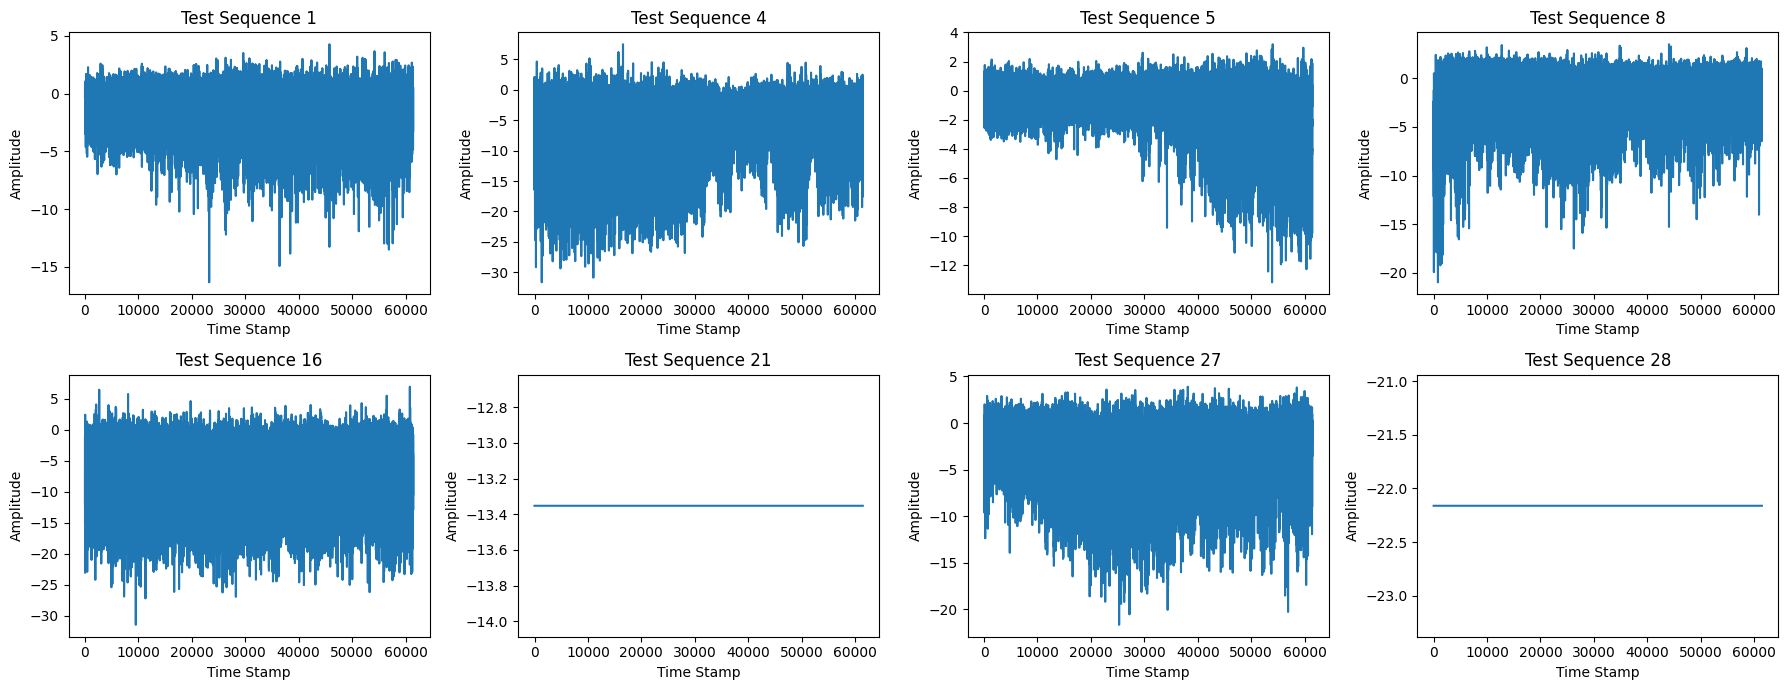

In [27]:
# Detected by both
index_list = [1,4,5,8,16,21,27,28]

fig, axs = plt.subplots(2, 4, figsize=(18, 7))
axs = axs.ravel()
for i, item in enumerate(index_list):
    axs[i].plot(test_data.T[item])
    axs[i].set_title(f"Test Sequence {item}")
    axs[i].set_xlabel('Time Stamp')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('detected_by_both.png', dpi=300)
plt.show()

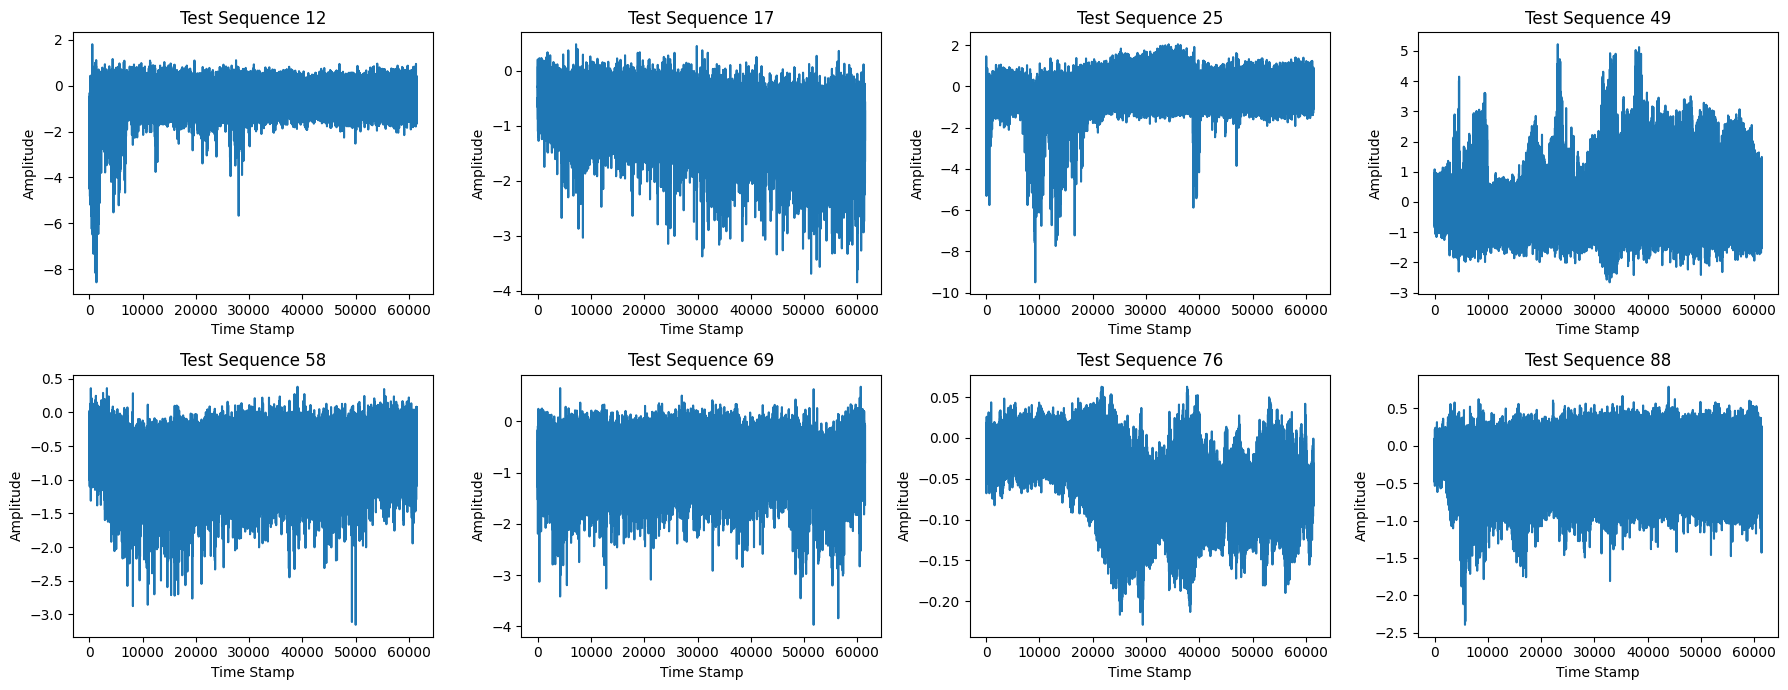

In [28]:
# Detected by LSTM missed by IFT
index_list = [12,17,25,49,58,69,76,88]

fig, axs = plt.subplots(2, 4, figsize=(18, 7))
axs = axs.ravel()
for i, item in enumerate(index_list):
    axs[i].plot(test_data.T[item])
    axs[i].set_title(f"Test Sequence {item}")
    axs[i].set_xlabel('Time Stamp')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('detected_by_lstm.png', dpi=300)
plt.show()

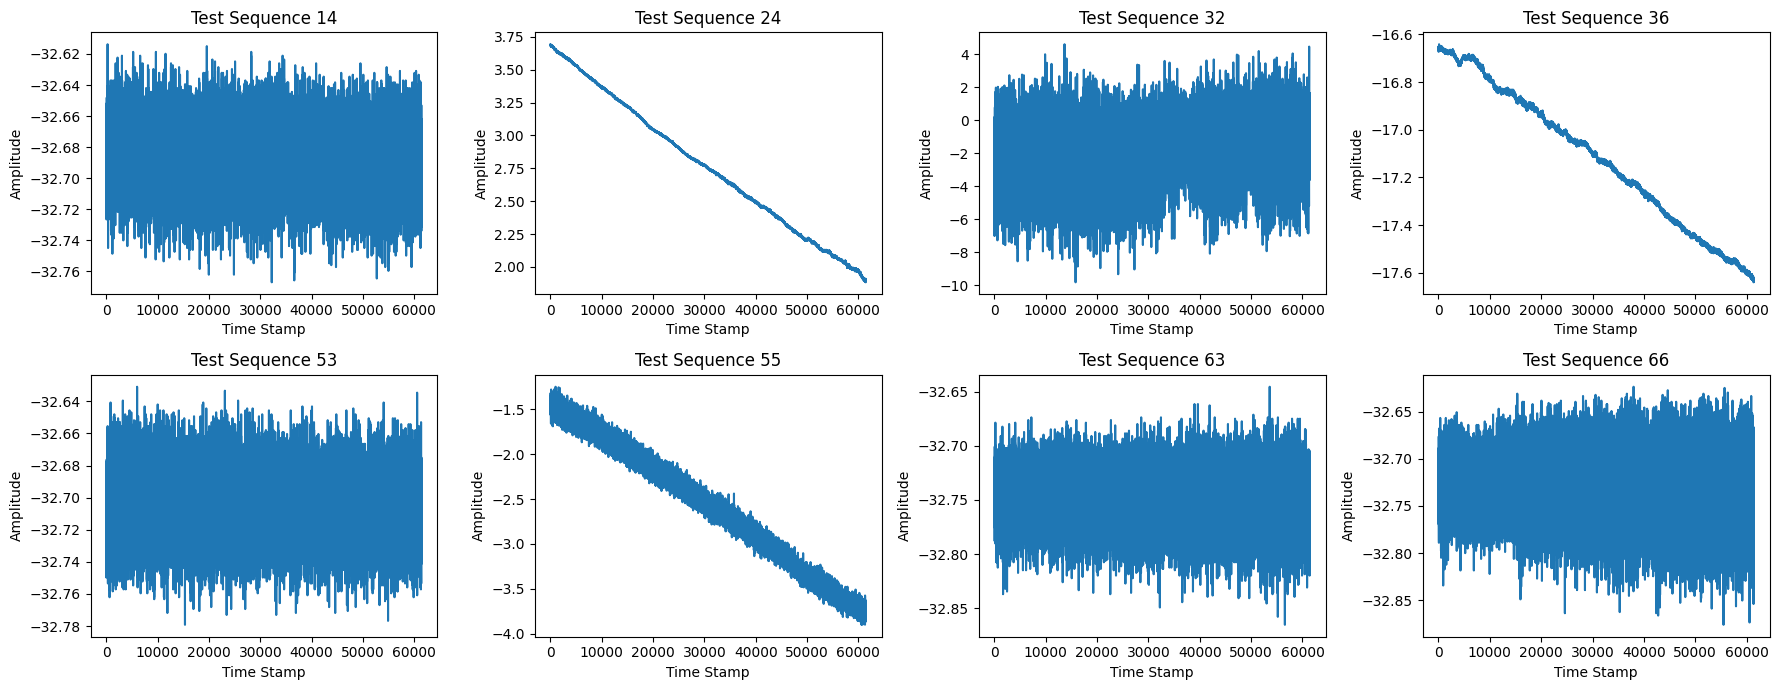

In [29]:
# Detected by IFT missed by LSTM
index_list = [14,24,32,36,53,55,63,66]

fig, axs = plt.subplots(2, 4, figsize=(18, 7))
axs = axs.ravel()
for i, item in enumerate(index_list):
    axs[i].plot(test_data.T[item])
    axs[i].set_title(f"Test Sequence {item}")
    axs[i].set_xlabel('Time Stamp')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('detected_by_ift.png', dpi=300)
plt.show()

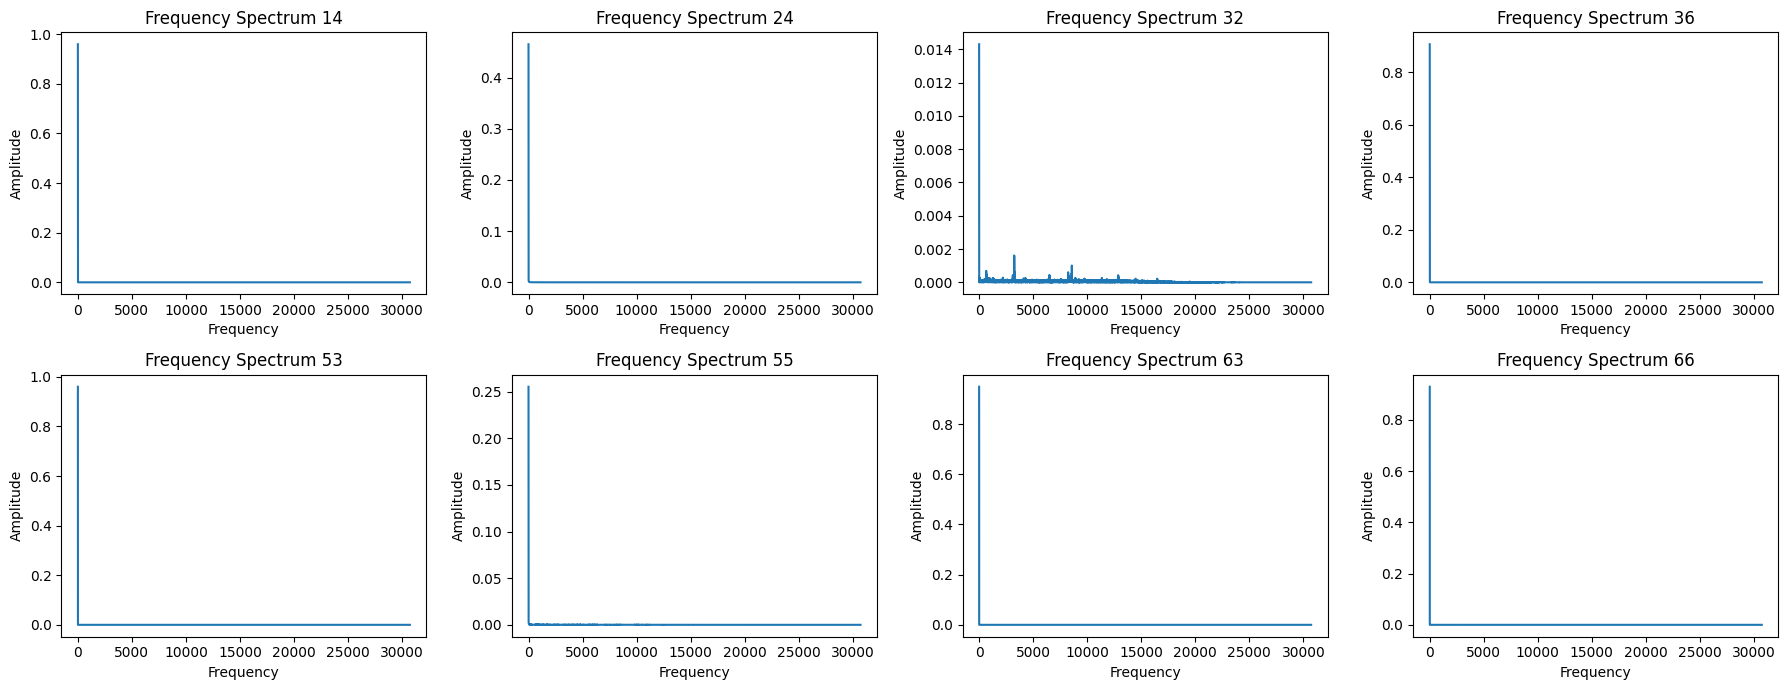

In [30]:
# Detected by IFT missed by LSTM (Frequency)
index_list = [14,24,32,36,53,55,63,66]


fig, axs = plt.subplots(2, 4, figsize=(18, 7))
axs = axs.ravel()
for i, item in enumerate(index_list):
    axs[i].plot(normalized_fft_data_test[item])
    axs[i].set_title(f"Frequency Spectrum {item}")
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Amplitude')
plt.tight_layout()
plt.savefig('detected_by_ift_freq.png', dpi=300)
plt.show()